# Import the necessary Libraries

In [1]:
!pip install pytorch-pretrained-bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 6.5 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings("ignore") 
import os
import numpy as np
import pickle
from nltk.corpus import stopwords
import string

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import classification_report

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)
    print(n_gpu)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

1
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Load the data

In [3]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df =  pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [6]:
print(len(train_df))
train_df = train_df.drop_duplicates('text', keep='last')
print(len(train_df))

7613
7503


# Exploratory Data Analysis of tweets
First,we will do very basic analysis,that is character level,word level and sentence level analysis.

0    4307
1    3196
Name: target, dtype: int64


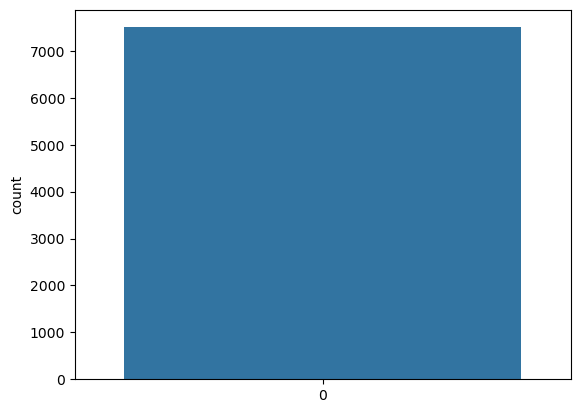

In [7]:
print(train_df['target'].value_counts())
sns.countplot(train_df['target'])
plt.show()

Unique keywords num=222
Unique keywords num=222


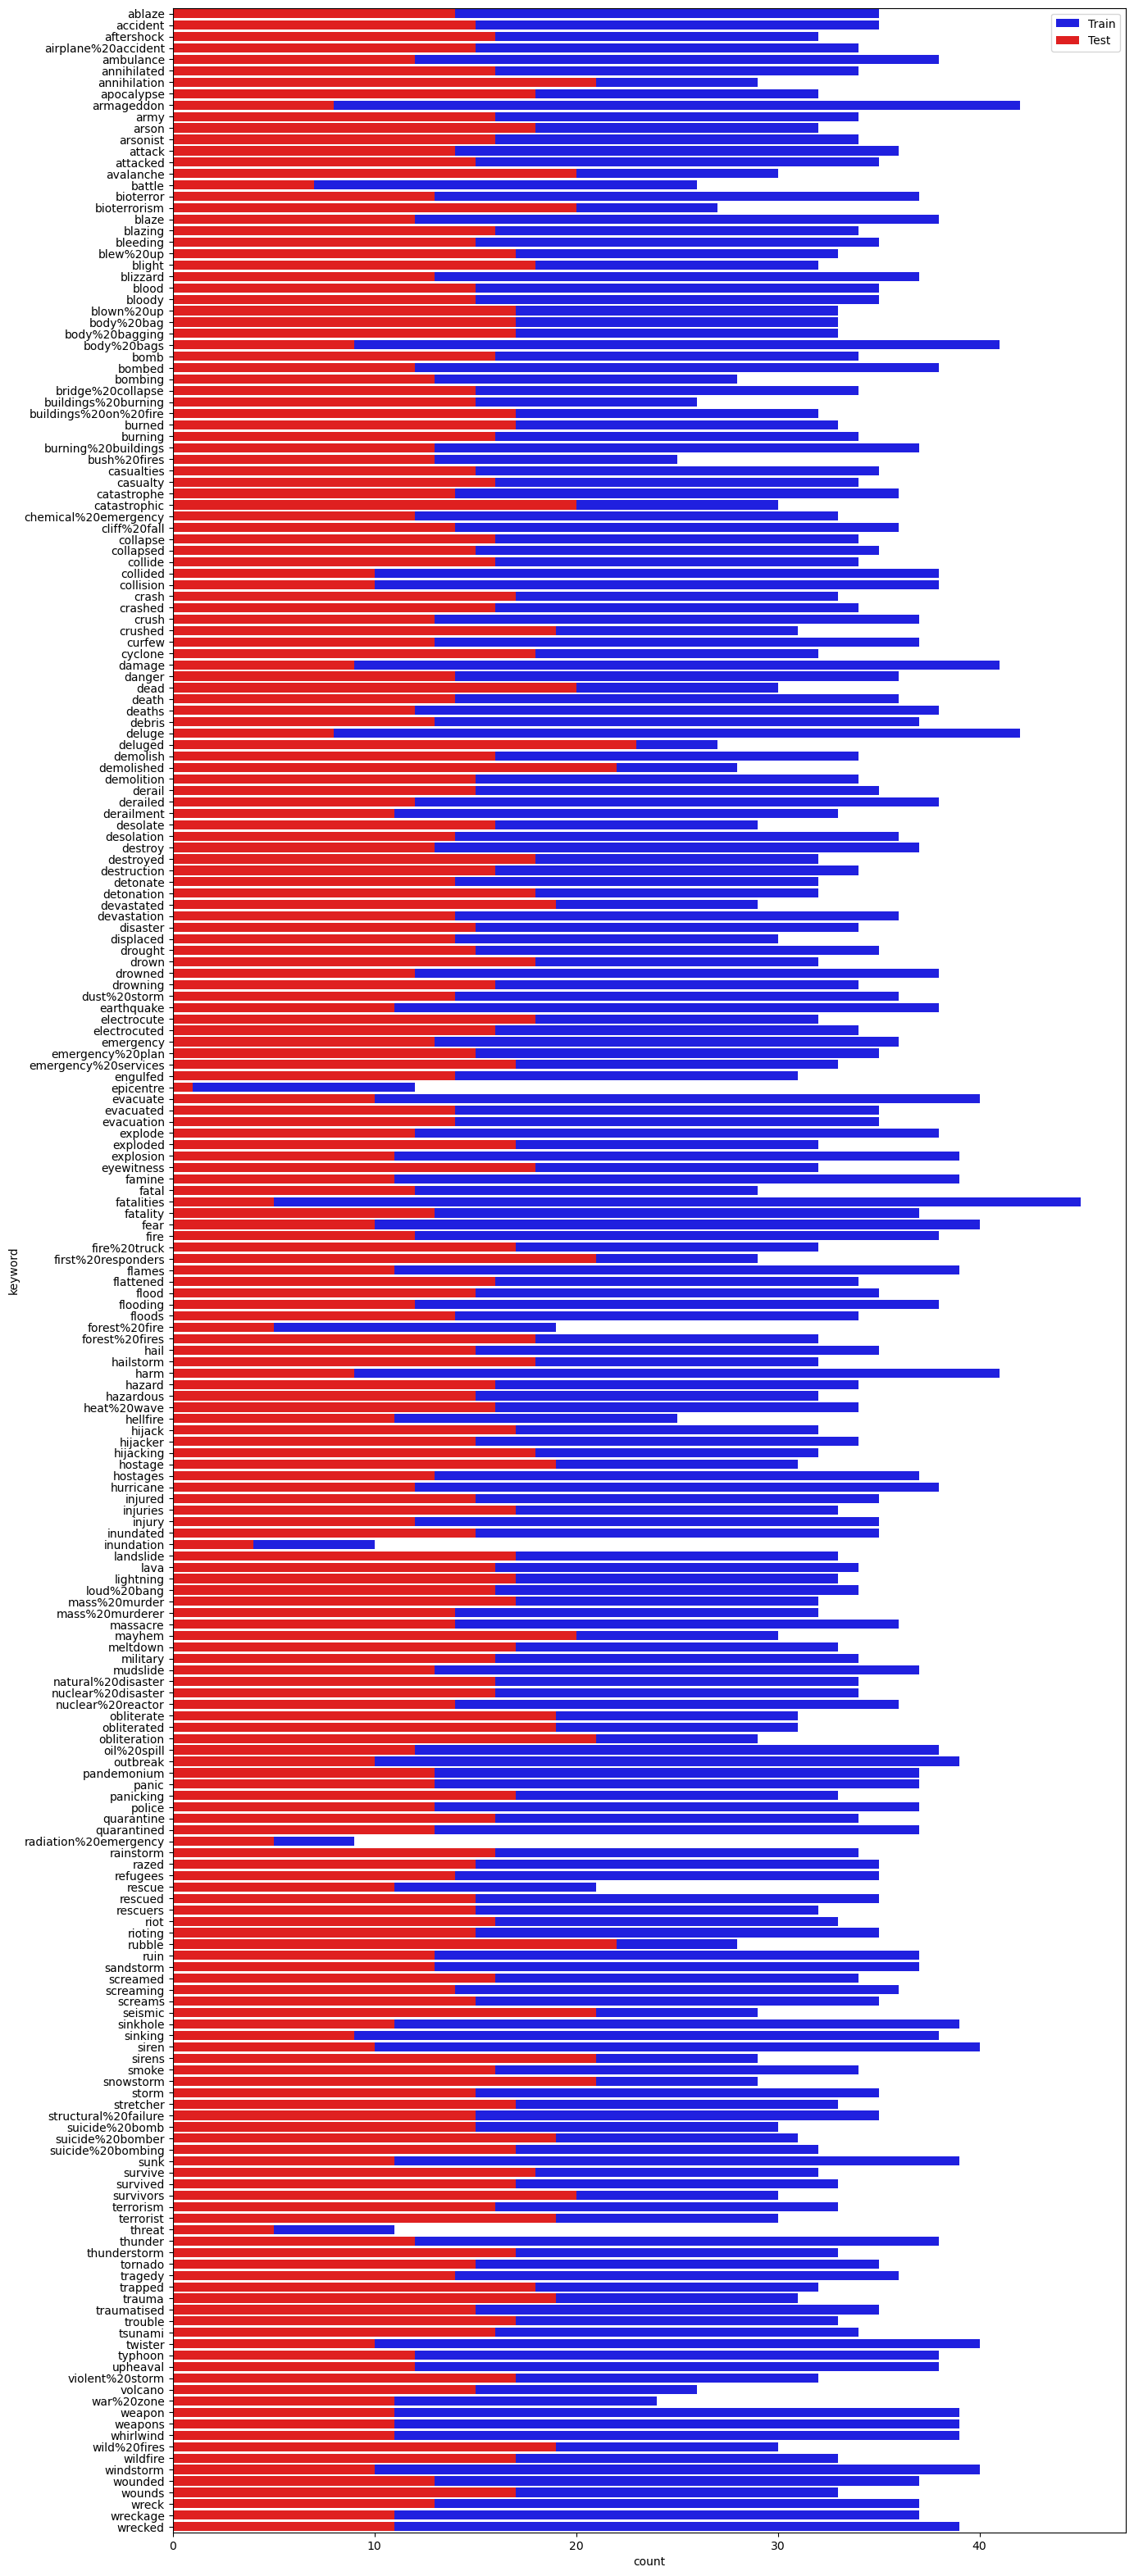

In [8]:
plt.figure(figsize=(15,40))
print(f'Unique keywords num={len(train_df.keyword.unique())}')
print(f'Unique keywords num={len(test_df.keyword.unique())}')
sns.countplot(y=train_df['keyword'], color=(0,0,1), label='Train')
sns.countplot(y=test_df['keyword'], color=(1,0,0), label='Test')
plt.legend()
plt.show()

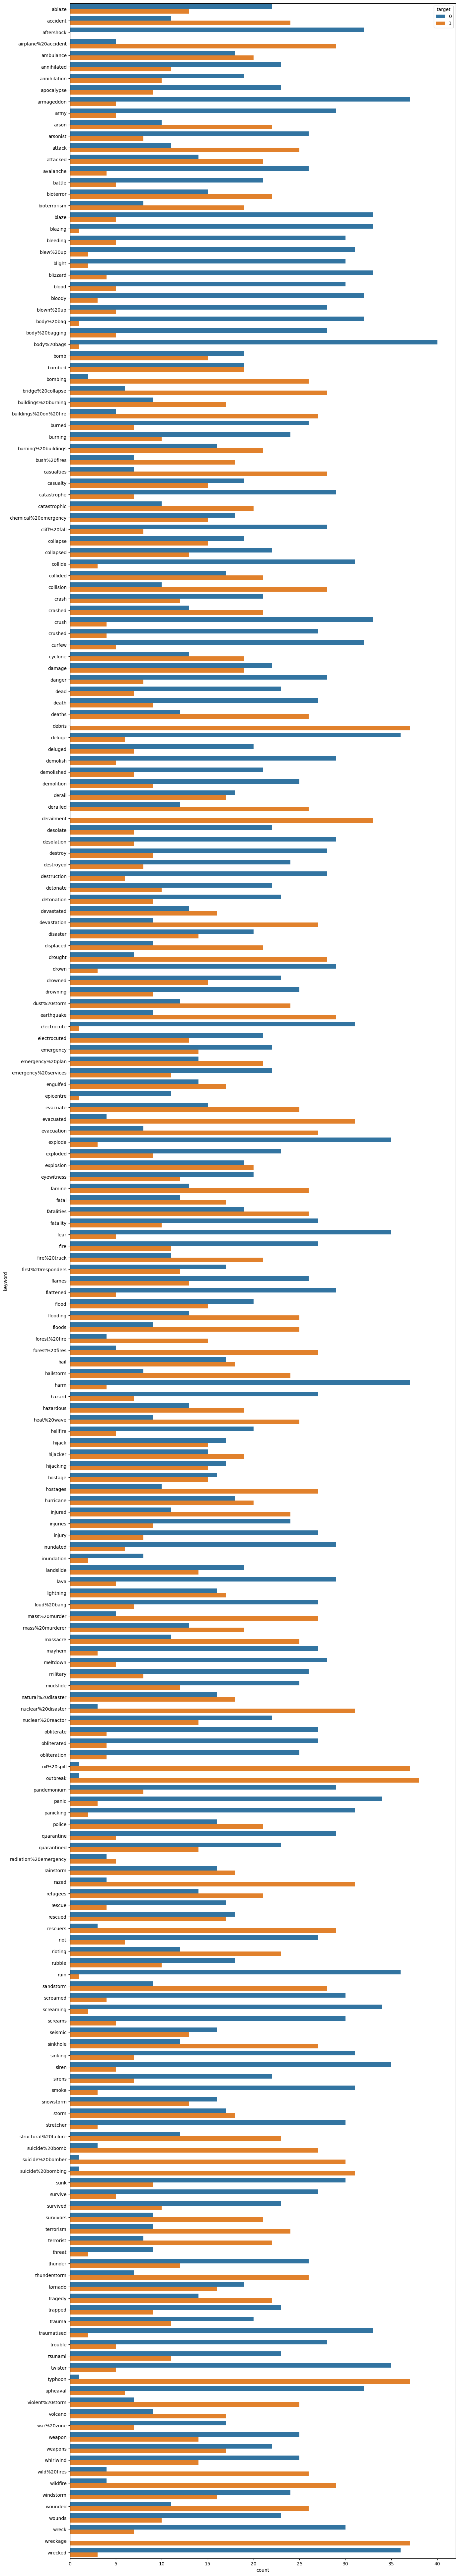

In [9]:
plt.figure(figsize=(15,100))
sns.countplot(data=train_df, y='keyword', hue='target')
plt.show()

# Preprocessing

In [10]:
#cleaning the text
from bs4 import BeautifulSoup
import re

def preprocess_text(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub('\[[^]]*\]', '', soup.get_text())
    pattern=r"[^a-zA-z0-9\s,']"
    text=re.sub(pattern,'',text)
    return text

train_df['text']=train_df['text'].apply(preprocess_text)
test_df['text']=test_df['text'].apply(preprocess_text)

BERT expects input data in a specific format

* We are performing a classification task so we use a special token [CLS] to indicate this to BERT.
* It needs to know the end of a sentence so we use the [SEP] token.

In [11]:
#BERT needs to understand 2 things:
#1) The start and end of each sentiment
# so we declare a special token CLS which tells BERT that its a classification task
sentences = train_df['text']
sentence = ["[CLS] "+i+" [SEP]" for i in sentences]

sentence[0]

'[CLS] Our Deeds are the Reason of this earthquake May ALLAH Forgive us all [SEP]'

In [12]:
test_sentences = test_df['text']
test_sentences = ["[CLS] "+i+" [SEP]" for i in test_sentences]

test_sentences[0]

'[CLS] Just happened a terrible car crash [SEP]'

# Tokenization
We now need to tokenize our text into tokens that correspond to BERT’s vocabulary.

In [13]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 388339.33B/s]


In [14]:
%%time
Stopwords = set(stopwords.words("english"))

# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
tokenized_texts = []
for text in sentence:
    Tokens = tokenizer.tokenize(text) # Restricting the max size of Tokens to 512(BERT doest accept any more than this)
    tokens = []
    for token in Tokens:
        if token not in Stopwords and not token.isdigit() and token not in string.punctuation:
            tokens.append(token)
          
    tokenized_texts.append(tokens)

CPU times: user 4.37 s, sys: 13.8 ms, total: 4.39 s
Wall time: 4.47 s


In [15]:
%%time
Stopwords = set(stopwords.words("english"))

# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
test_tokenized_texts = []
for text in test_sentences:
    Tokens = tokenizer.tokenize(text) # Restricting the max size of Tokens to 512(BERT doest accept any more than this)
    tokens = []
    for token in Tokens:
        if token not in Stopwords and not token.isdigit() and token not in string.punctuation:
            tokens.append(token)
          
    test_tokenized_texts.append(tokens)

CPU times: user 1.76 s, sys: 6.81 ms, total: 1.77 s
Wall time: 1.78 s


### **Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary¶**

In [16]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
text_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
test_text_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_tokenized_texts]

### Padding

In [17]:
# Set the maximum sequence length. 
MAX_LEN = 128

input_ids = pad_sequences(text_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
test_ids = pad_sequences(test_text_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

### BERT is a MLM(Masked Language Model). We have to define its mask.¶

In [18]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [19]:
# Create attention masks for test data
test_attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in test_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)

In [20]:
print ("Tokenized first sentence:")
print (tokenized_texts[0])
print ('Tokenized first sentence Length :',len(tokenized_texts[0]))
print()

print ("convert the tokens to their index numbers in the BERT vocabulary:")
print(tokenizer.convert_tokens_to_ids(tokenized_texts[0]))
print()

print ("Padding")
print('Before Padding, Length :',len(text_ids[0]))
print('Before Text ids :',text_ids[0])
print('After Padding, Length :',len(input_ids[0]))
print('After Text input ids :',input_ids[0])

print()
print('Mask',attention_masks[0])
print('Mask length :',len(attention_masks[0]))

Tokenized first sentence:
['[CLS]', 'deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us', '[SEP]']
Tokenized first sentence Length : 9

convert the tokens to their index numbers in the BERT vocabulary:
[101, 15616, 3114, 8372, 2089, 16455, 9641, 2149, 102]

Padding
Before Padding, Length : 9
Before Text ids : [101, 15616, 3114, 8372, 2089, 16455, 9641, 2149, 102]
After Padding, Length : 128
After Text input ids : [  101 15616  3114  8372  2089 16455  9641  2149   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0

In [21]:
# Select a batch size for training. 
batch_size = 16

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, 
                                                                                    train_df['target'].tolist(), 
                                                                                    random_state=23, 
                                                                                    test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=23, 
                                                       test_size=0.2)

In [22]:
print(len(train_inputs), len(train_masks), len(train_labels))
print(len(validation_inputs),len(validation_labels), len(validation_masks))

6002 6002 6002
1501 1501 1501


### Convert all of our data into torch tensors, the required datatype for our model

In [23]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

test_inputs = torch.tensor(test_ids)
test_masks = torch.tensor(test_attention_masks)

### Create an iterator of our data with torch DataLoader¶

In [24]:
batch_size = 32
# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Load the model

In [25]:
#Loading pre trained BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)#binary classification
if torch.cuda.is_available():
    print(model.cuda())
else:
    print(model)

100%|██████████| 407873900/407873900 [00:32<00:00, 12379190.21B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

# BERT fine-tuning parameters¶

In [26]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

torch.cuda.empty_cache() 

In [27]:
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 2

# BERT training loop
for i in range(epochs):
    print('Epoch -->',i+1)
    # TRAINING
    # Set our model to training mode
    model.train()  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    
    # Train the data for one epoch
    for step, batch in tqdm(enumerate(train_dataloader)):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
    # VALIDATION

    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch --> 1


188it [01:34,  1.98it/s]


Train loss: 0.47961052142559213
Validation Accuracy: 0.8266461848862803
Epoch --> 2


188it [01:32,  2.02it/s]


Train loss: 0.320471321767632
Validation Accuracy: 0.8287096478356567


# Prediction

In [28]:
pred_label = []
valid_label = []
for text, attention, label in tqdm(validation_dataloader):
    text = text.to(device)
    attention = attention.to(device)
    label = label.to(device)
    pred = model(text, token_type_ids=None, attention_mask=attention)
    pred = pred.detach().cpu().numpy()
    valid = np.argmax(pred, axis = 1)
    pred_label.append(valid)
    valid_label.append(label.detach().cpu().numpy())


100%|██████████| 47/47 [00:06<00:00,  7.54it/s]


In [29]:
# Convert lists to numpy arrays
pred_label = np.concatenate(pred_label)
valid_label = np.concatenate(valid_label)

# Generate classification report
report = classification_report(valid_label, pred_label)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       846
           1       0.82      0.78      0.80       655

    accuracy                           0.83      1501
   macro avg       0.83      0.82      0.83      1501
weighted avg       0.83      0.83      0.83      1501



# Submission

In [30]:
test_inputs.shape
test_data = TensorDataset(test_inputs, test_masks)
test_dataloader = DataLoader(test_data)

predicts = []
for text, attention in tqdm(test_dataloader):
    text = text.to(device)
    attention = attention.to(device)
    pred = model(text, token_type_ids=None, attention_mask=attention)
    pred = pred.detach().cpu().numpy()
    prediction = np.argmax(pred)
    predicts.append(prediction)

100%|██████████| 3263/3263 [00:53<00:00, 60.68it/s]


In [31]:
submission['target']= predicts
submission.to_csv('final_submission.csv', index=False, header=True)
df = pd.read_csv('final_submission.csv')
df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [32]:
df['target'].value_counts()

0    1963
1    1300
Name: target, dtype: int64